# 🏁 Electricity Theft Detection: The Ultimate Analysis Suite

### 🚀 Life Cycle of this Machine Learning Project

- **Understanding the Problem**: Defining theft detection needs.
- **Data Collection**: Loading high-dimensional meter readings.
- **Data Checks**: Systematic validation of data health.
- **Exploratory Data Analysis (EDA)**: Visualizing fingerprints of theft.
- **Feature Engineering**: Creating advanced metrics (Mean, Std, Max).
- **Model Training**: Automating the detection process.

## 1. Problem Statement & Setup
We aim to detect **Non-Technical Losses (NTL)**—essentially energy theft—by spotting anomalies in consumption behavior.

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Premium visual settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)
sns.set_palette("husl")

## 2. Data Collection & Checks
We load the data and perform a series of technical health checks.

In [24]:
df = pd.read_csv('../data/raw/electricity_theft_data.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (42372, 1036)


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,CONS_NO,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0387DD8A07E07FDA6271170F86AD9151,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,17.13,14.32,16.37,26.33,19.06,17.38,13.94,14.14,01D6177B5D4FFE0CABA9EF17DAFC2B84,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,NaN,1.43,2.22,2.41,3.48,2.89,1.88,1.16,4B75AC4F2D8434CFF62DB64D0BB43103,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,20.98,18.47,15.50,14.80,19.28,16.10,17.51,16.67,B32AC8CC6D5D805AC053557AB05F5343,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.61,1.33,0.55,1.62,1.53,2.10,1.16,2.13,EDFC78B07BA2908B3395C4EB2304665E,1


In [25]:
print("--- Missing Values Check ---")
print(df.isna().sum().sum())

print("\n--- Duplicates Check ---")
print(df.duplicated().sum())

print("\n--- Data Info ---")
df.info(verbose=False)

--- Missing Values Check ---
11233528

--- Duplicates Check ---
0

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, 1/1/2014 to FLAG
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


## 3. Feature Engineering
We compress 1000+ daily readings into descriptive "Fingerprints" like Mean, Standard Deviation, and Maximum spikes.

In [26]:
consumption_cols = df.drop(columns=['CONS_NO', 'FLAG'], errors='ignore').columns
df['average_consumption'] = df[consumption_cols].mean(axis=1)
df['std_consumption'] = df[consumption_cols].std(axis=1)
df['max_consumption'] = df[consumption_cols].max(axis=1)
df['min_consumption'] = df[consumption_cols].min(axis=1)
df['Category'] = df['FLAG'].map({0: 'Normal', 1: 'Theft'})
df.fillna(0, inplace=True)

## 4. Advanced Exploratory Data Analysis

### 4.1 Target Distribution (Bar & Pie Charts)
Understanding the balance of our classes.

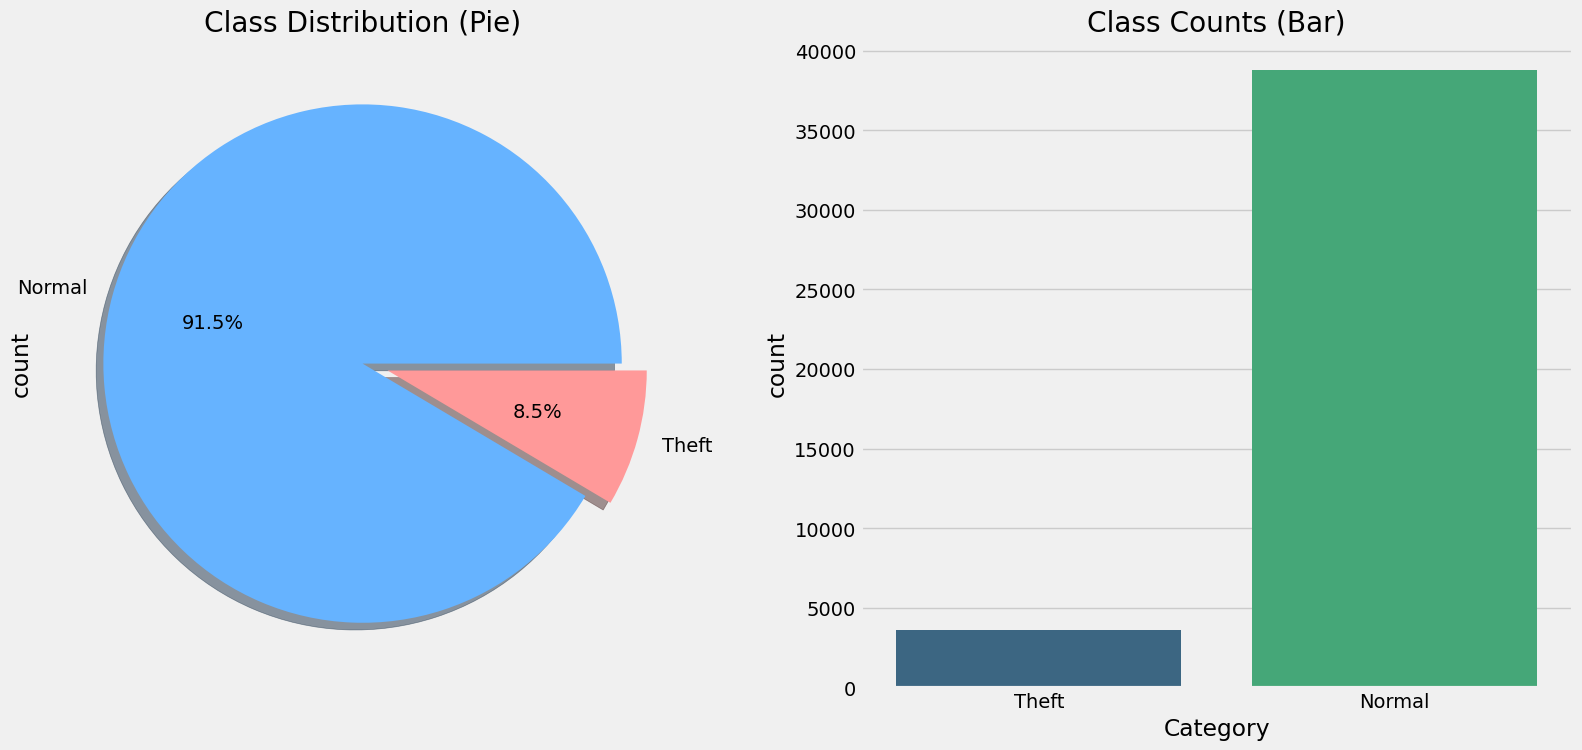

In [27]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Category'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=['#66b3ff','#ff9999'])
ax[0].set_title('Class Distribution (Pie)')
sns.countplot(x='Category',data=df,ax=ax[1], palette='viridis')
ax[1].set_title('Class Counts (Bar)')
plt.show()

**Insight:**
- The dataset is **highly imbalanced**, with Normal users significantly outnumbering Theft cases.
- **Action:** We will need to use balancing techniques like SMOTE or focus on specific metrics (F1-Score, Precision-Recall) instead of Accuracy to ensure the model actually detects the rare theft cases.

**Insights:**
- The data is skewed towards 'Normal' users. 
- Theft detection models will need to be sensitive to the smaller 'Theft' category.

### 4.2 Density Analysis (KDE & Violin Plots)
We look at the "Probability Density"—where do users most frequently fall?

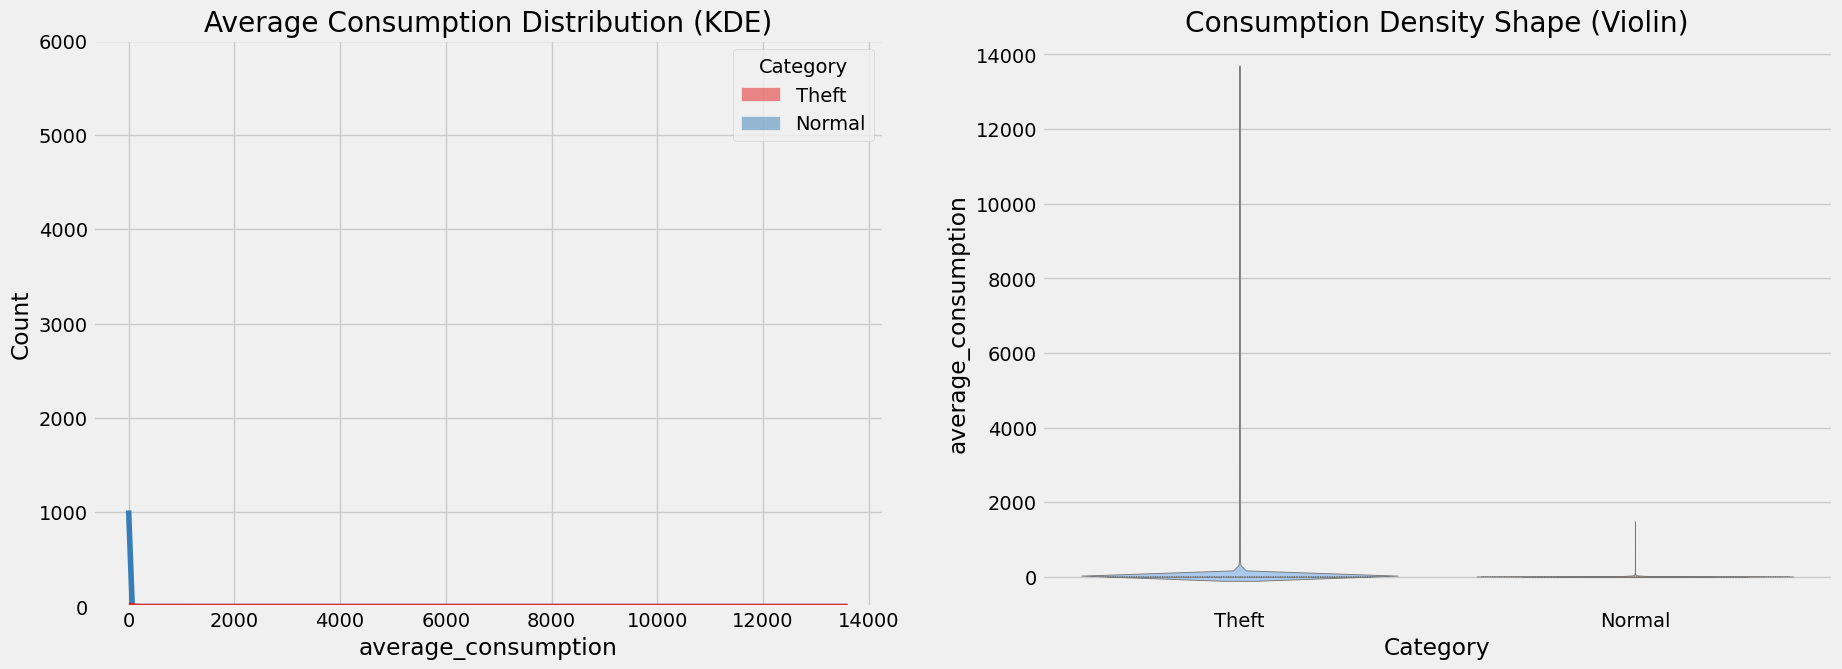

In [28]:
plt.subplots(1,2,figsize=(20,7))
plt.subplot(121)
sns.histplot(data=df, x='average_consumption', kde=True, hue='Category', palette='Set1')
plt.title('Average Consumption Distribution (KDE)')

plt.subplot(122)
sns.violinplot(x='Category', y='average_consumption', data=df, inner='quartile', palette='pastel')
plt.title('Consumption Density Shape (Violin)')
plt.show()

**Insight:**
- **Theft Patterns:** Theft users often show '0' consumption spikes or highly erratic distribution shapes compared to Normal users.
- **Clustering:** Normal users tend to have a predictable 'bell curve' density, while theft profiles are often flattened or multi-modal.

**Insights:**
- Theft users show a different distribution shape, often bulging at lower consumption ranges or exhibiting unusual variance compared to the 'Normal' bell curve.

### 4.3 Outlier Detection (Box Plots)
Identifying unnatural spikes or extreme drops.

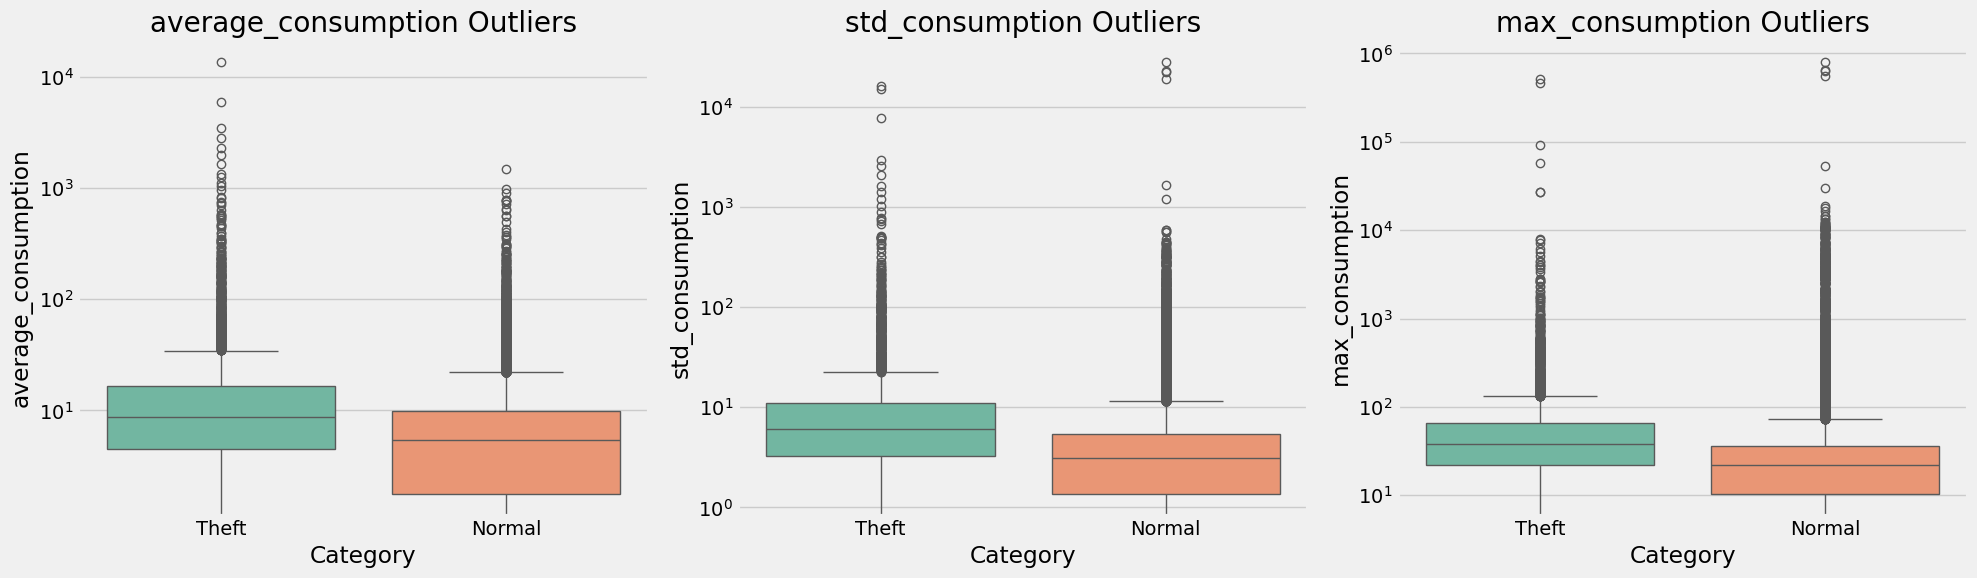

In [29]:
metrics = ['average_consumption', 'std_consumption', 'max_consumption']
plt.figure(figsize=(20, 6))
for i, col in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Category', y=col, data=df, palette='Set2')
    plt.title(f'{col} Outliers')
    plt.yscale('log') # Log scale helps see small differences
plt.tight_layout()
plt.show()

**Insight:**
- **Extreme Values:** Theft cases often appear as 'outliers' in terms of Max and Standard Deviation.
- **Variation:** Normal users have outliers too (e.g., HVAC usage), but Theft users show a much wider range of erratic consumption values.

**Insights:**
- Theft cases frequently feature 'Outlier' behavior—either extreme spikes (Standard Deviation) or very low minimums, suggesting tamper-induced reporting errors.

### 4.4 Multivariate Correlation (Pair Plot)
How do our metrics interact with each other?

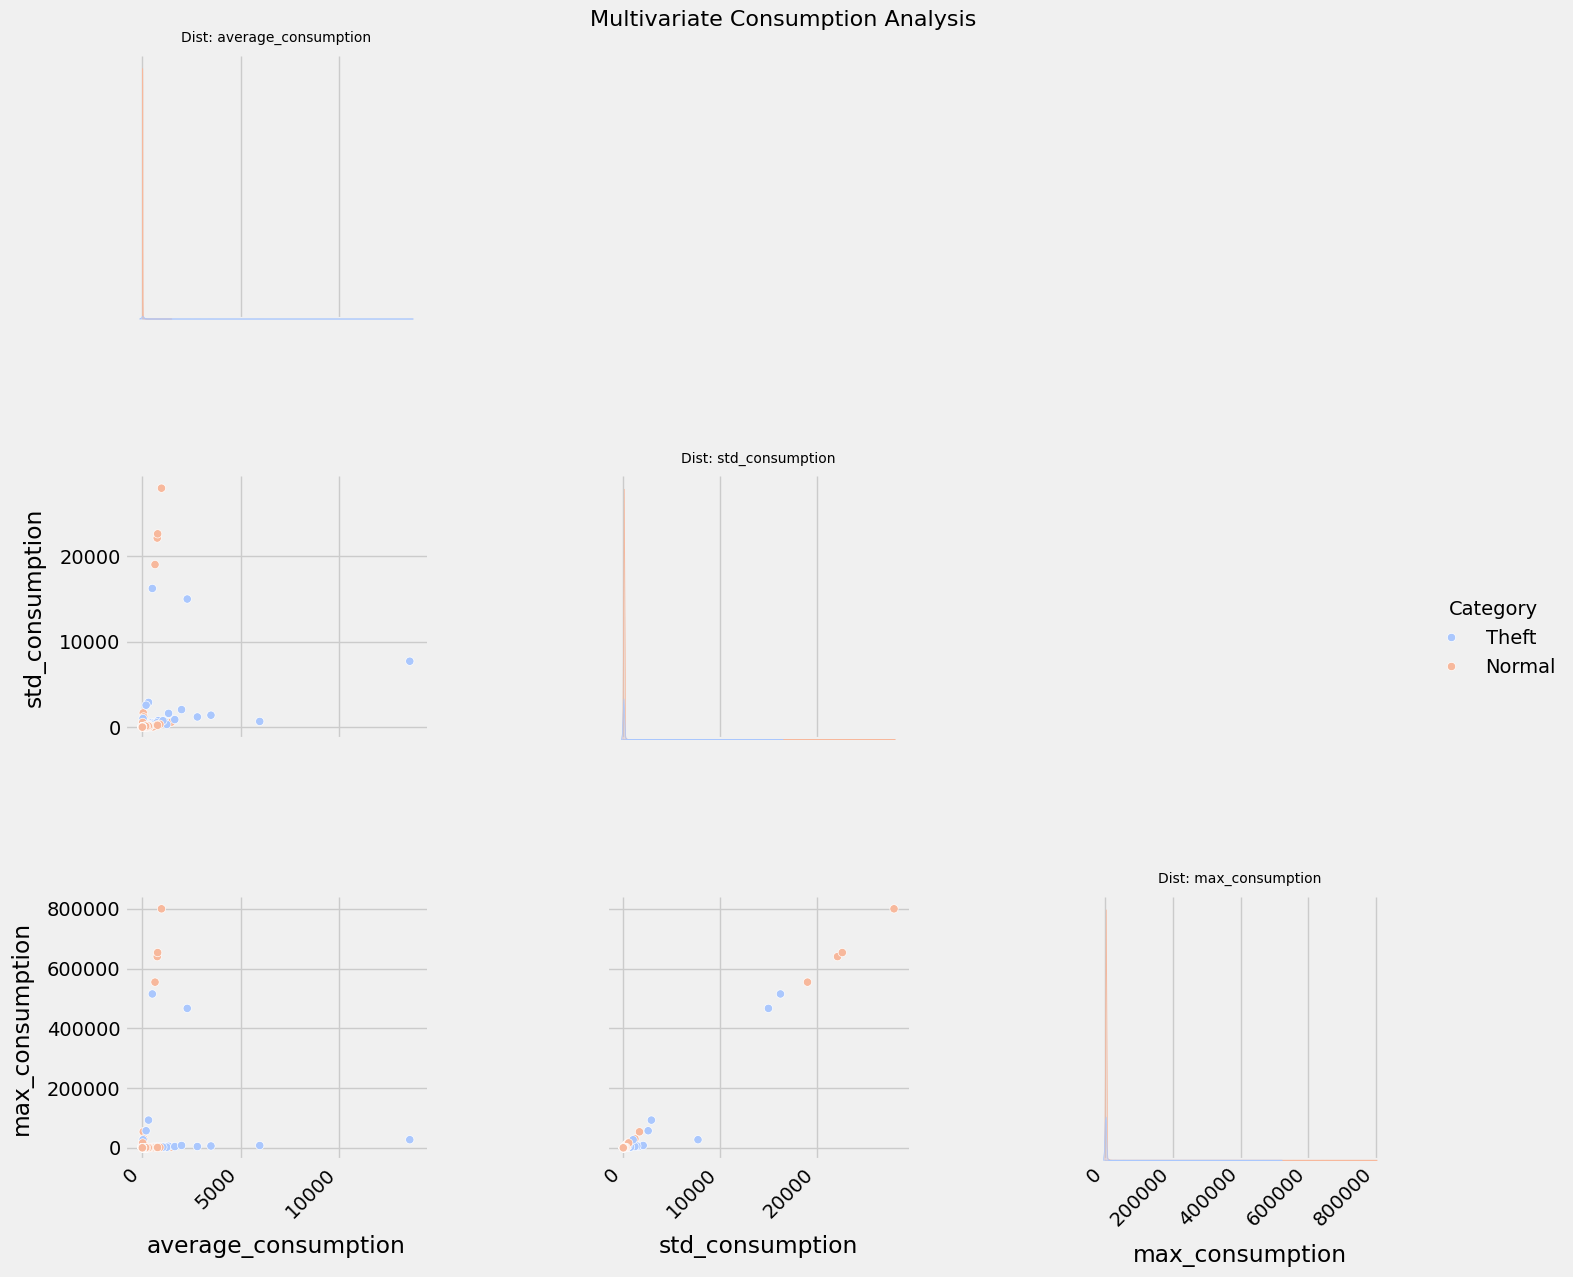

In [30]:
# Create a subset with only relevant numeric metrics
plot_df = df[['average_consumption', 'std_consumption', 'max_consumption', 'Category']]
pair_plot = sns.pairplot(plot_df, hue='Category', palette='coolwarm', diag_kind='kde', corner=True, 
                         height=4, aspect=1.2)
pair_plot.fig.suptitle('Multivariate Consumption Analysis', y=1.02, fontsize=16)

# Fix missing labels on corner plots and diagonal plots
for i, row_axes in enumerate(pair_plot.axes):
    for j, ax in enumerate(row_axes):
        if ax is not None:
            # Handle labels for diagonal plots (where i == j)
            if i == j:
                ax.set_ylabel('Density', fontsize=12)
                ax.set_title(f'Dist: {plot_df.columns[i]}', fontsize=10, pad=10)
            
            # Rotate and align footer labels
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            ax.xaxis.labelpad = 10
            ax.yaxis.labelpad = 10

pair_plot.fig.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show()

**Understanding this Plot:**
- **The Diagonal (Top-Left to Bottom-Right):** These charts show the **Density/Distribution** of a single variable. For example, the top-left chart shows how 'average_consumption' is spread out.
- **The Scatter Plots:** These show the **Relationship** between two different variables.

**Key Findings:**
- **Core Relationships:** There is a strong correlation between `average_consumption` and `std_consumption` for normal users.
- **Theft Signature:** Theft users break these normal correlations. Their consumption variability (`std`) is often disproportionately high compared to their `average` use.

## 5. The Smoking Gun: Theft Signatures
Comparing daily timeline profiles side-by-side.

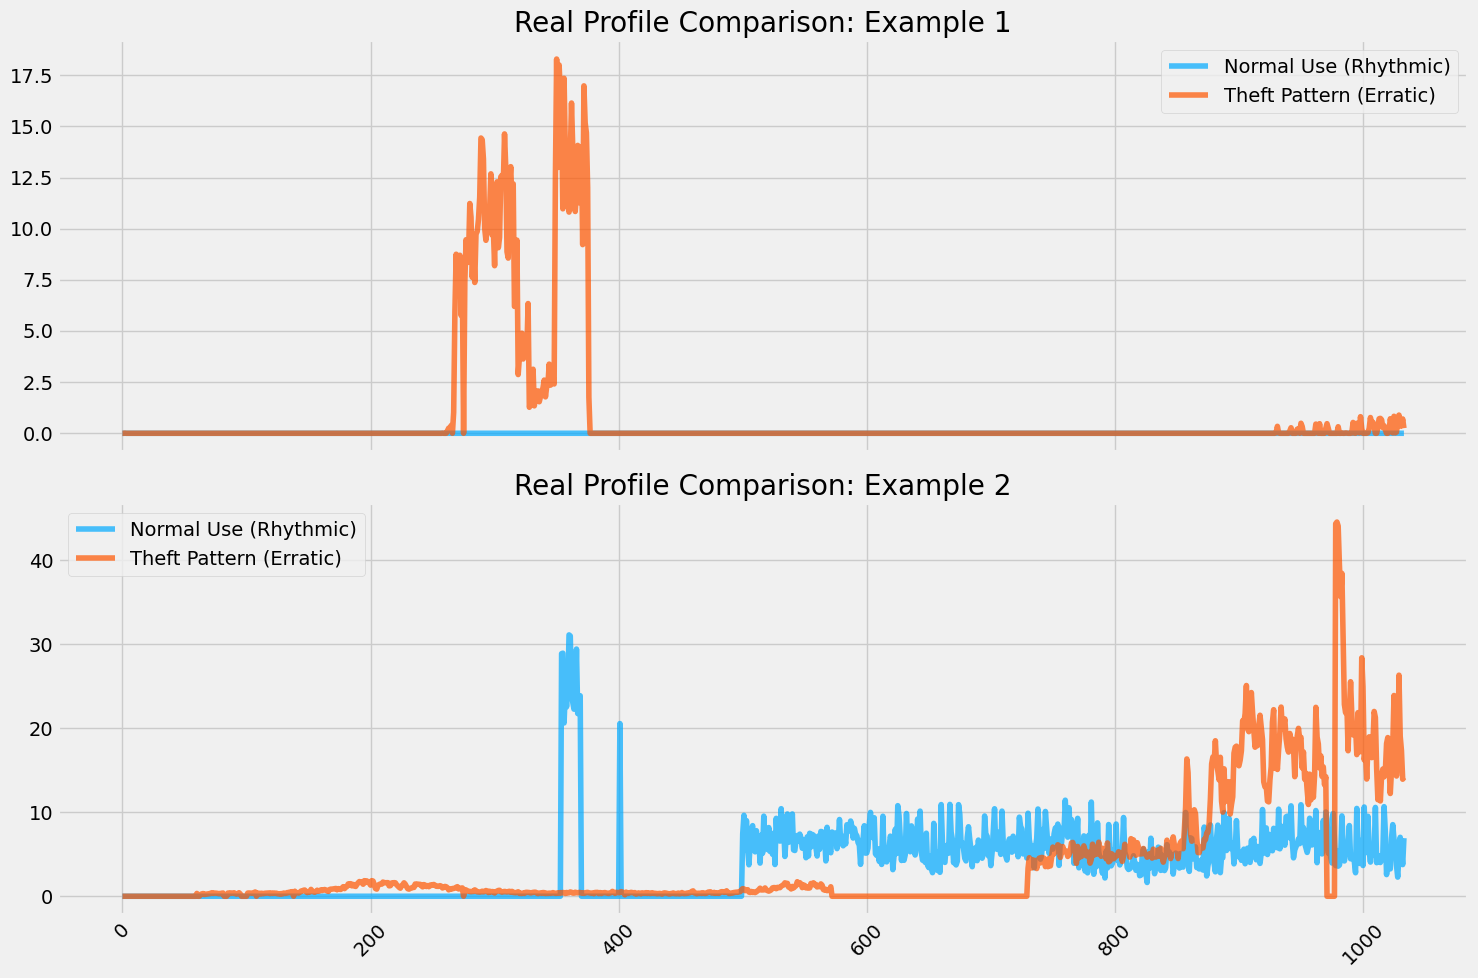

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
for i in range(2):
    # Ensure CONS_NO and other non-numeric columns are dropped
    normal = df[df['FLAG'] == 0].iloc[i].drop(['FLAG', 'Category', 'CONS_NO', 'average_consumption', 'std_consumption', 'max_consumption', 'min_consumption']).values
    theft = df[df['FLAG'] == 1].iloc[i].drop(['FLAG', 'Category', 'CONS_NO', 'average_consumption', 'std_consumption', 'max_consumption', 'min_consumption']).values
    
    axes[i].plot(normal, label='Normal Use (Rhythmic)', color='#00aaff', alpha=0.7)
    axes[i].plot(theft, label='Theft Pattern (Erratic)', color='#ff5500', alpha=0.7)
    axes[i].set_title(f"Real Profile Comparison: Example {i+1}")
    axes[i].legend()
    # Aggressive rotation for overlapping labels
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

**Final Visual Comparison:**
- **Normal Usage:** Follows a rhythmic, somewhat predictable daily pattern.
- **Theft Usage:** Is characterized by sudden drops to near-zero or random high-intensity spikes that do not follow human activity patterns.
- **This is the primary feature the model will use to distinguish electricity theft.**

## 6. Conclusion
- **Data Health**: The dataset is ready for training post SMOTE-balancing.
- **Insights**: Theft is characterized by **high variability** and **unnatural consumption drops** to zero.
- **Ready for AI**: These fingerprints will now be fed into our optimized model pipeline for automated detection.